In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'imblearn'

In [2]:
# Load the dataset
file_path = './winequality-red.csv'  # Update with the correct path if necessary
wine_data = pd.read_csv(file_path, delimiter=';')

In [3]:
# Step 1: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(wine_data.head())
print("\nDataset Information:")
wine_data.info()
print("\nSummary Statistics:")
print(wine_data.describe())

Dataset Overview:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2 

In [4]:
# Check for missing values
missing_values = wine_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)



Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


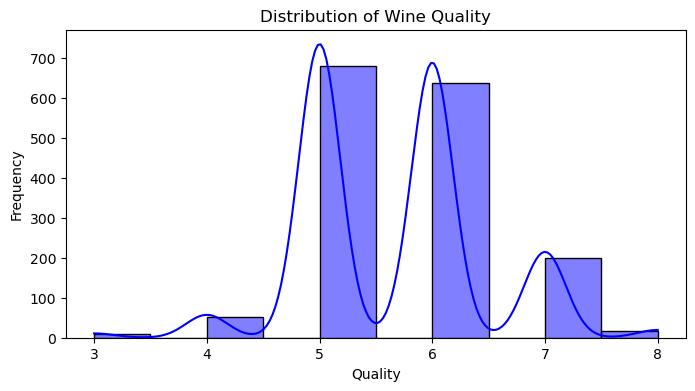

In [5]:
# Plot distributions of features
plt.figure(figsize=(8, 4))
sns.histplot(wine_data['quality'], kde=True, bins=10, color='blue')
plt.title("Distribution of Wine Quality")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.show()

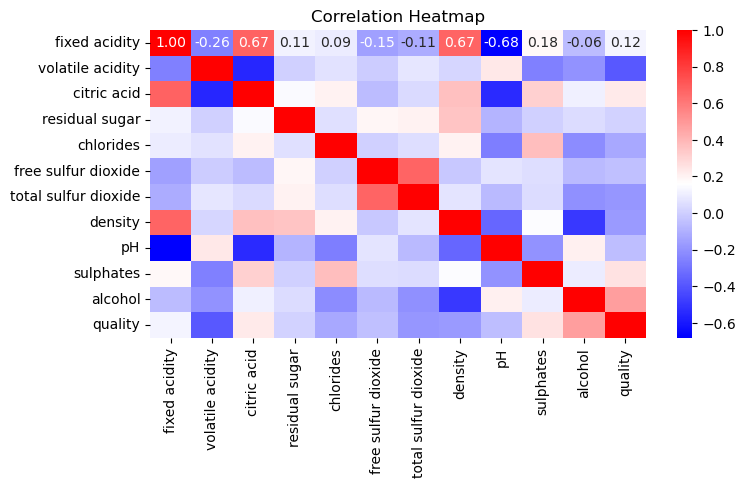

In [6]:
# Correlation heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(wine_data.corr(), annot=True, fmt=".2f", cmap="bwr")
plt.title("Correlation Heatmap")
plt.show()

In [7]:
# Step 2: Data Preprocessing

# Normalize the features (for regression tasks)
scaler = MinMaxScaler()
X = wine_data.iloc[:, :-1]  # All features except 'quality'
X_scaled = scaler.fit_transform(X)

In [8]:
# Target for classification and regression
y_classification = wine_data['quality'].apply(lambda q: 'low' if q <= 5 else 'high')
y_regression = wine_data['quality']

In [9]:
# Address class imbalance for classification
over_sampler = SMOTE(random_state=42)
X_scaled_balanced, y_classification_balanced = over_sampler.fit_resample(X_scaled, y_classification)

In [10]:
# Train-test split for both tasks
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled_balanced, y_classification_balanced, test_size=0.2, random_state=42
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_regression, test_size=0.2, random_state=42
)

In [11]:
# Step 3: Implement Decision Tree Models

# Hyperparameter tuning for the classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
classifier_grid = GridSearchCV(classifier, classifier_params, cv=5, scoring='accuracy')
classifier_grid.fit(X_train_class, y_train_class)
best_classifier = classifier_grid.best_estimator_


In [12]:
# Train the regressor
regressor = DecisionTreeRegressor(random_state=42)
regressor_params = {
    'criterion': ['squared_error'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
regressor_grid = GridSearchCV(regressor, regressor_params, cv=5, scoring='neg_mean_squared_error')
regressor_grid.fit(X_train_reg, y_train_reg)
best_regressor = regressor_grid.best_estimator_

In [13]:
# Step 4: Model Evaluation

# Evaluate Classifier
y_pred_class = best_classifier.predict(X_test_class)
classification_accuracy_train = accuracy_score(y_train_class, best_classifier.predict(X_train_class))
classification_accuracy_test = accuracy_score(y_test_class, y_pred_class)
print("Classification Model Results:")
print(f"Train Accuracy: {classification_accuracy_train:.2f}")
print(f"Test Accuracy: {classification_accuracy_test:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

Classification Model Results:
Train Accuracy: 1.00
Test Accuracy: 0.75
Confusion Matrix:
[[139  47]
 [ 39 117]]
Classification Report:
              precision    recall  f1-score   support

        high       0.78      0.75      0.76       186
         low       0.71      0.75      0.73       156

    accuracy                           0.75       342
   macro avg       0.75      0.75      0.75       342
weighted avg       0.75      0.75      0.75       342



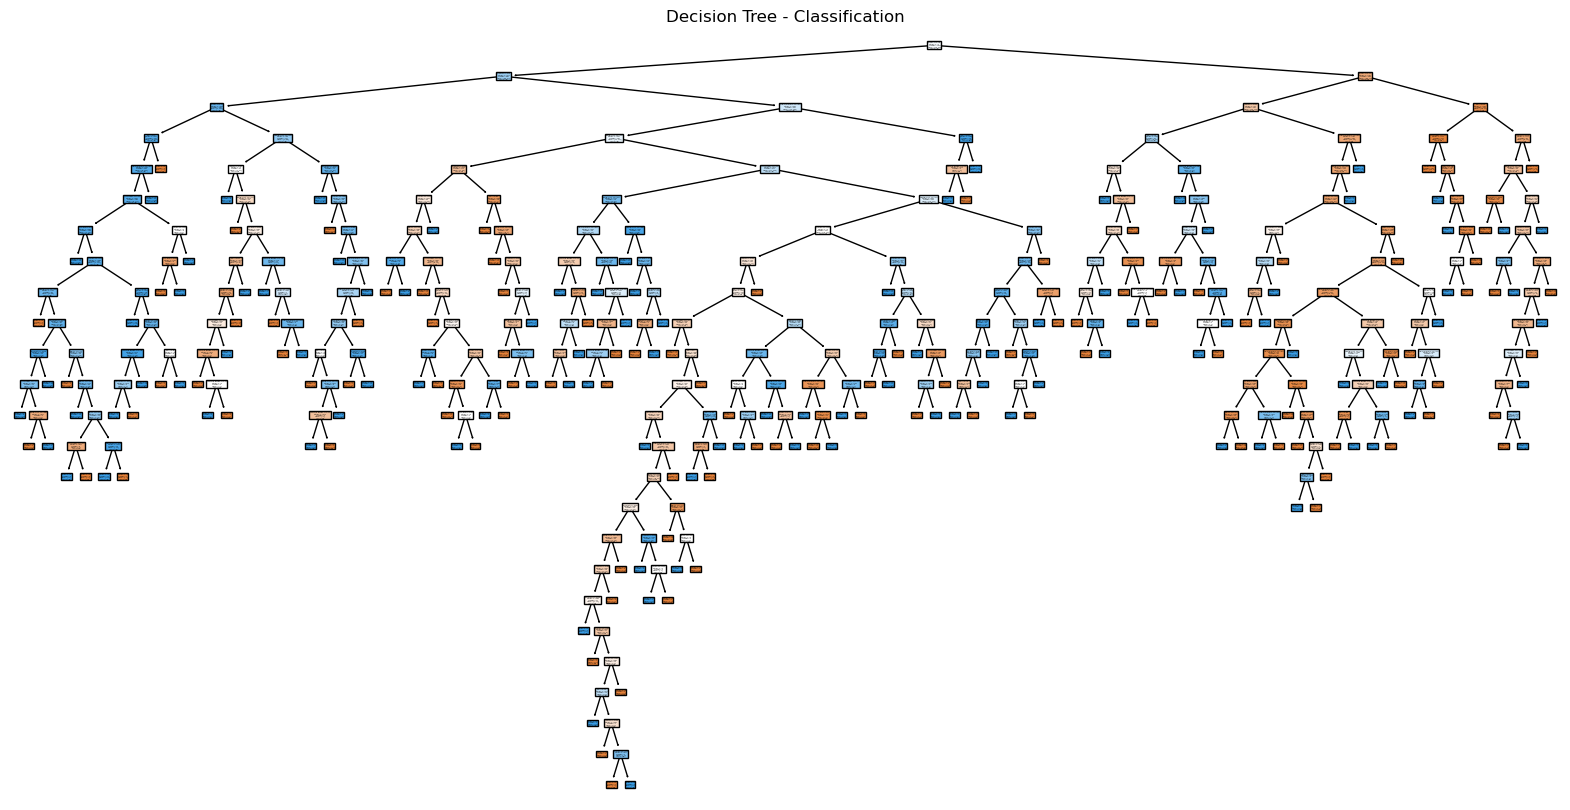

In [14]:
# Visualize decision tree for classification
plt.figure(figsize=(20, 10))
plot_tree(best_classifier, feature_names=wine_data.columns[:-1], class_names=['low', 'high'], filled=True)
plt.title("Decision Tree - Classification")
plt.show()


In [15]:
# Evaluate Regressor
y_pred_reg = best_regressor.predict(X_test_reg)
regression_mse_train = mean_squared_error(y_train_reg, best_regressor.predict(X_train_reg))
regression_mse_test = mean_squared_error(y_test_reg, y_pred_reg)
regression_r2_train = r2_score(y_train_reg, best_regressor.predict(X_train_reg))
regression_r2_test = r2_score(y_test_reg, y_pred_reg)
print("\nRegression Model Results:")
print(f"Train Mean Squared Error: {regression_mse_train:.2f}")
print(f"Test Mean Squared Error: {regression_mse_test:.2f}")
print(f"Train R-Squared: {regression_r2_train:.2f}")
print(f"Test R-Squared: {regression_r2_test:.2f}")


Regression Model Results:
Train Mean Squared Error: 0.18
Test Mean Squared Error: 0.49
Train R-Squared: 0.72
Test R-Squared: 0.25


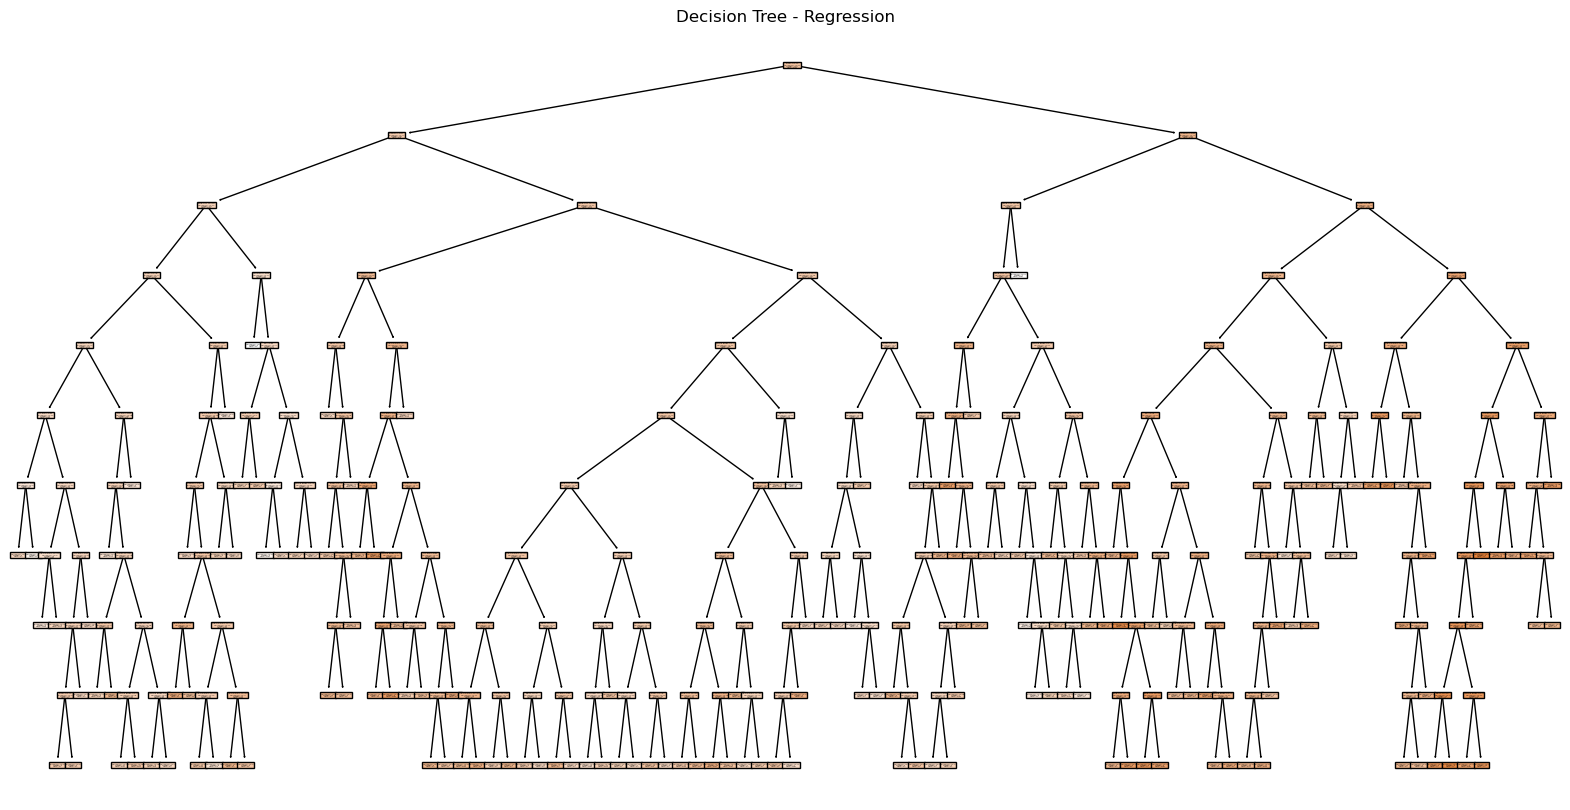

In [16]:
# Visualize decision tree for regression
plt.figure(figsize=(20, 10))
plot_tree(best_regressor, feature_names=wine_data.columns[:-1], filled=True)
plt.title("Decision Tree - Regression")
plt.show()


In [17]:
# Step 5: Evaluate Quality of Red Wine
wine_data['predicted_quality'] = best_regressor.predict(X_scaled).round()
print("\nQuality Evaluation of Red Wine:")
print(wine_data[['quality', 'predicted_quality']].head(10))


Quality Evaluation of Red Wine:
   quality  predicted_quality
0        5                5.0
1        5                5.0
2        5                6.0
3        6                6.0
4        5                5.0
5        5                5.0
6        5                5.0
7        7                6.0
8        7                6.0
9        5                5.0


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


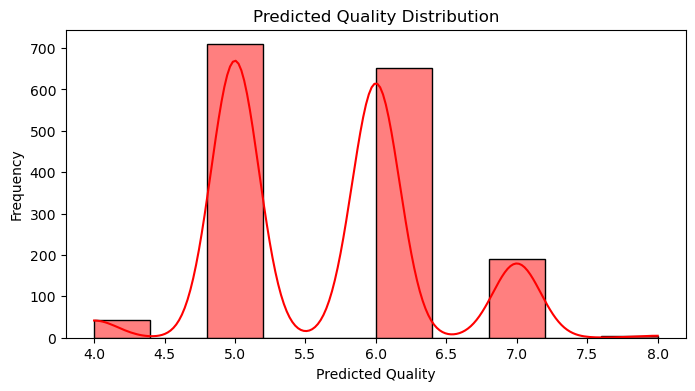

In [18]:
# Distribution of predicted quality
plt.figure(figsize=(8, 4))
sns.histplot(wine_data['predicted_quality'], kde=True, bins=10, color='red')
plt.title("Predicted Quality Distribution")
plt.xlabel("Predicted Quality")
plt.ylabel("Frequency")
plt.show()


In [21]:
wine_data['predicted_classification'] = wine_data['predicted_quality'].apply(lambda x: 'low' if x <= 5 else 'high')
final_accuracy = accuracy_score(wine_data['quality'].apply(lambda q: 'low' if q <= 5 else 'high'), wine_data['predicted_classification'])
print(f"Final Classification Accuracy Based on Predicted Quality: {final_accuracy:.2f}")
print(f"Final Classification Accuracy Based on Predicted Quality: {final_accuracy * 100:.2f}%")



Final Classification Accuracy Based on Predicted Quality: 0.85
Final Classification Accuracy Based on Predicted Quality: 85.18%
